In [159]:
%pylab inline

import os
import pandas as pd
import gzip

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Paths
COREDIR = "/storage/pandaman/project/AgentBind-GM12878-DanQ-unfixed-rnn-trans/storage/AgentBind-GM12878-DanQ/tmp/"

# Data for the hit
#chrom = "chr6"; pos = 31535454 # LTA, TNF region lots of info on this one
#chrom="chr3"; pos=101498076; # NXPE3
chrom="chr2"; pos=143886818; # ARHGAP15 #https://ashpublications.org/blood/article/118/4/1099/28906/The-RacGAP-ArhGAP15-is-a-master-negative-regulator
factor = "SP1"
gwasfile = "/storage/mgymrek/agent-bind/gwas-round2/indexed-data/wbc_summstats.bed.gz"

# Data files
maskfile = os.path.join(COREDIR, "%s+GM12878"%factor, "seqs_one_hot_b/vis-weights-total/weight.txt")

Populating the interactive namespace from numpy and matplotlib


In [160]:
WINDOW = 1000000 # 100000
def LoadGWAS(gwasfile, usechrom, usepos, WINDOW):
    pos = []
    pval = []
    rsid = []
    with gzip.open(gwasfile, "rt") as f:
        for line in f:
            items = line.strip().split()
            chrom = items[0]
            start = int(items[1])
            p = float(items[4])
            rs = items[3]
            if chrom!=usechrom: continue
            if usepos > start-WINDOW and usepos < start+WINDOW:
                pos.append(start)
                pval.append(p)
                rsid.append(rs)
    return pd.DataFrame({"pos": pos, "rsid": rsid, "pval": pval})
gwasdata = LoadGWAS(gwasfile, chrom, pos, WINDOW)

In [161]:
# chr7;38217660;38217671;38217166;38218166;+
#chr10;99078951;99078962;99078457;99079457;+
def LoadScores(weightfile, usechrom, usepos):
    f = open(weightfile, "r")
    locline = f.readline()
    wline = f.readline()
    ASIZE = 1000
    pos = [None]*ASIZE
    while locline.strip() != "":
        locitems = locline.split(";")
        chrom = locitems[0]
        start = int(locitems[3])
        end = int(locitems[4])
        if not ((chrom == usechrom) and (usepos>=start) and (usepos<=end)):
            locline = f.readline()
            wline = f.readline()
            continue
        print(locline)
        # Parse weights
        weights = [max([0, float(item)]) for item in wline.strip().split(";")]
        # Update weights and pos
        pos = list(range(start-1, start-1+ASIZE))
        return pd.DataFrame({"pos": pos, "weight": weights})
        locline = f.readline()
        wline = f.readline()
    return None

scoredata = LoadScores(maskfile, chrom, pos)

chr2;143886878;143886889;143886384;143887384;+



In [162]:
data = pd.merge(scoredata, gwasdata, on=["pos"], how="outer").sort_values("pos")

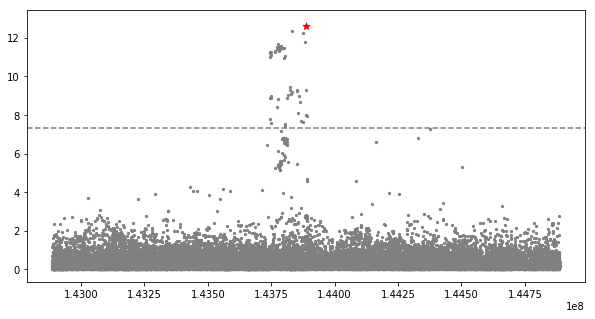

In [163]:
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.scatter(data["pos"], data["pval"].apply(lambda x: -1*np.log10(x)), color="gray", s=5)
ax.axhline(y=-1*np.log10(5*10**-8), linestyle="dashed", color="gray")

hit = data[data["pos"]==pos+1]
ax.scatter(hit["pos"], hit["pval"].apply(lambda x: -1*np.log10(x)), color="red", marker="*", s=50)

#ax2 = ax.twinx()
#ax2.scatter(data["pos"], data["weight"], color="darkblue", s=5);
#ax2.set_ylim(bottom=-0.0001, top=max(data[~np.isnan(data["weight"])]["weight"]))
fig.savefig("GWASExample-ARHGAP15.pdf")

In [164]:
!pwd

/storage/mgymrek/workspace/agent-bind-analyses/gwas


(143886784, 143887053)

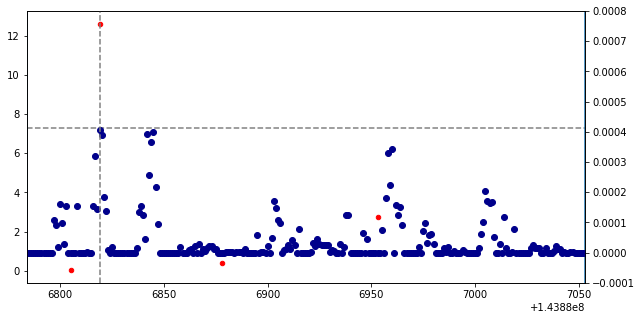

In [166]:
xdata = data[~np.isnan(data["weight"])]
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.scatter(xdata["pos"], xdata["pval"].apply(lambda x: -1*np.log10(x)), color="red", s=20)
ax.axhline(y=-1*np.log10(5*10**-8), linestyle="dashed", color="gray")
ax2 = ax.twinx()
ax2.scatter(xdata["pos"], xdata["weight"], color="darkblue");
ax2.set_ylim(bottom=-0.0001, top=0.0008)
ax2.axvline(x=pos+1, linestyle="dashed", color="gray"); #chr2:143,886,784-143,887,053
ax.axvline(x=143886784)
ax.axvline(x=143887053)
ax.set_xlim(left=143886784, right=143887053)